In [1285]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## Problem 1: Clustering

### A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. Please note that it is a summarized data that contains the average values in all the columns considering all the months, and not for any particular month. You are given the task to identify the segments based on credit card usage.

### 1.1 Read the data, do the necessary initial steps, and exploratory data analysis (Univariate, Bi-variate, and multivariate analysis).

In [1286]:
df = pd.read_csv(r'H:\Downloads\bank_marketing_part1_Data.csv')

In [1287]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


In [1288]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


In [1289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [1290]:
df.shape

(210, 7)

In [1291]:
df.isnull().sum()

spending                        0
advance_payments                0
probability_of_full_payment     0
current_balance                 0
credit_limit                    0
min_payment_amt                 0
max_spent_in_single_shopping    0
dtype: int64

In [1292]:
df.duplicated().sum()

0

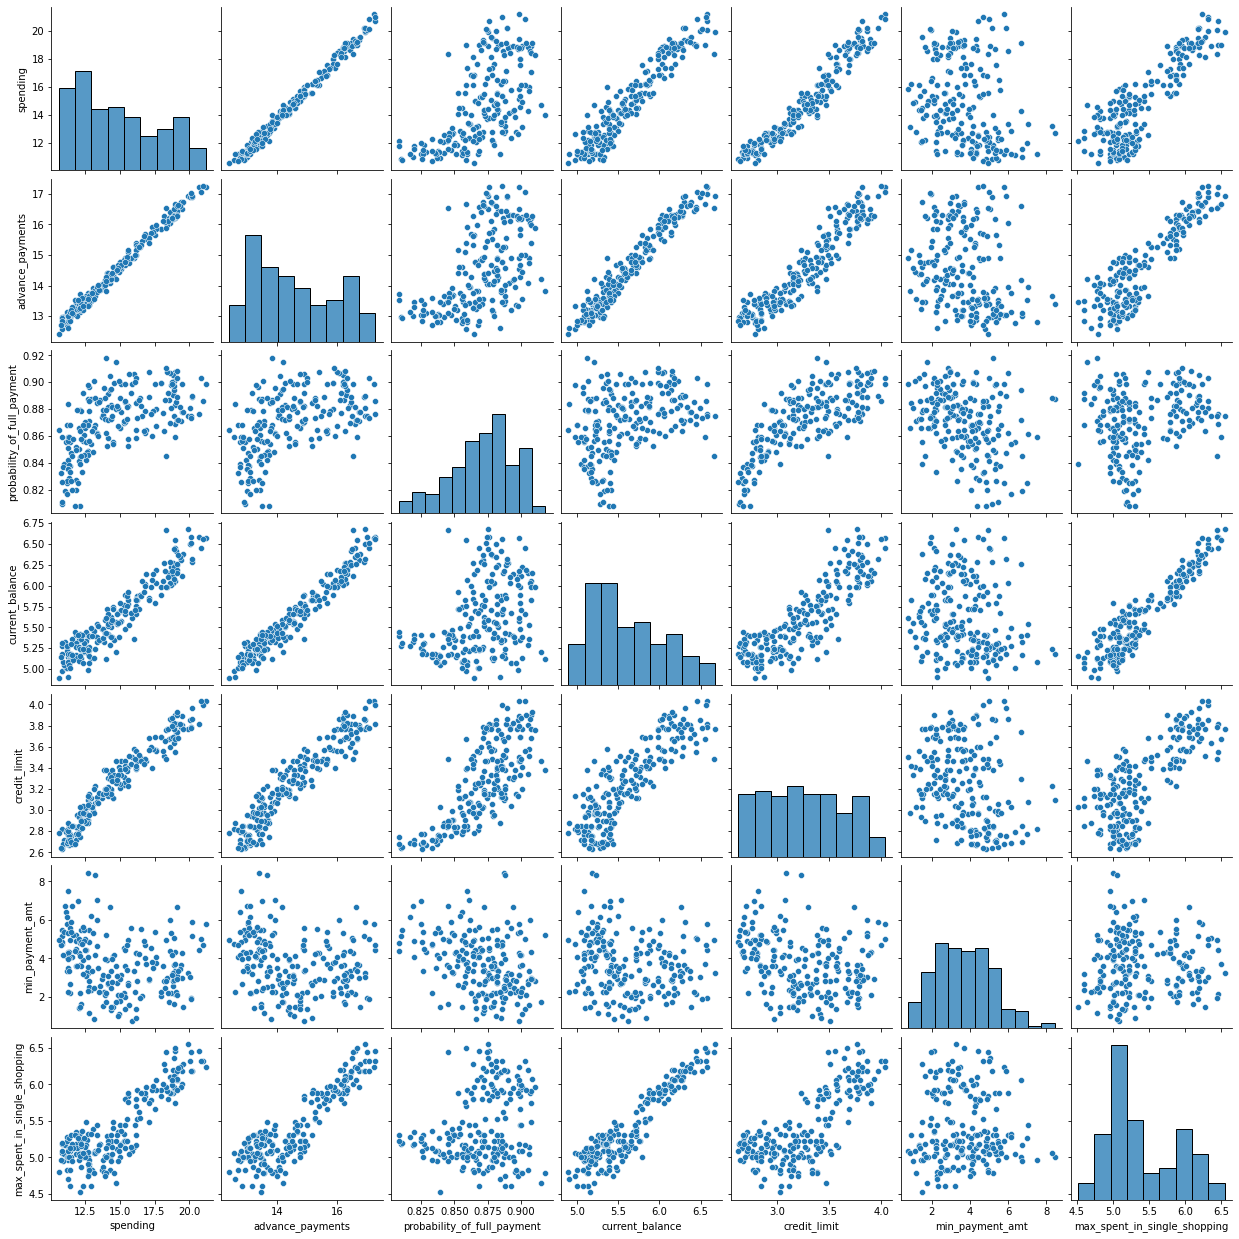

In [1293]:
sns.pairplot(data=df[['spending','advance_payments','probability_of_full_payment','current_balance','credit_limit','min_payment_amt','max_spent_in_single_shopping']]);

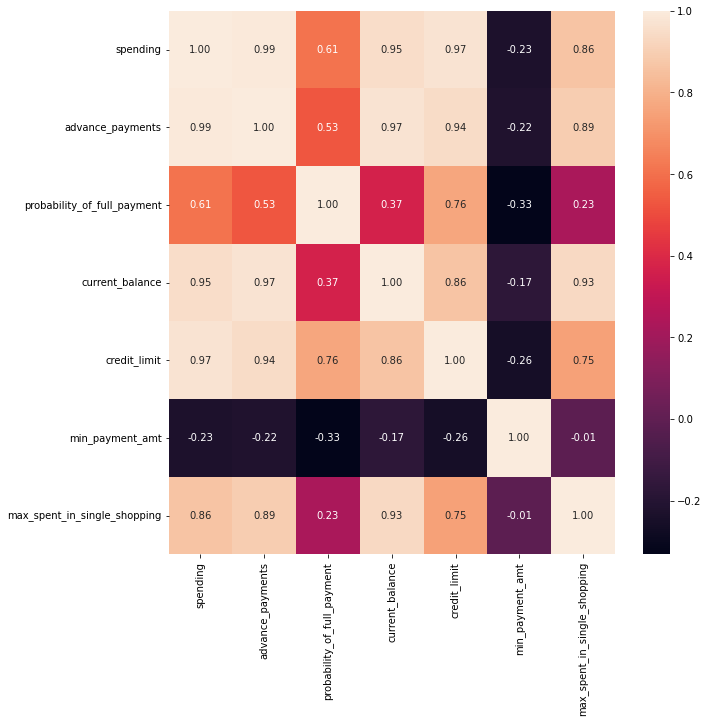

In [1294]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt=".2f");

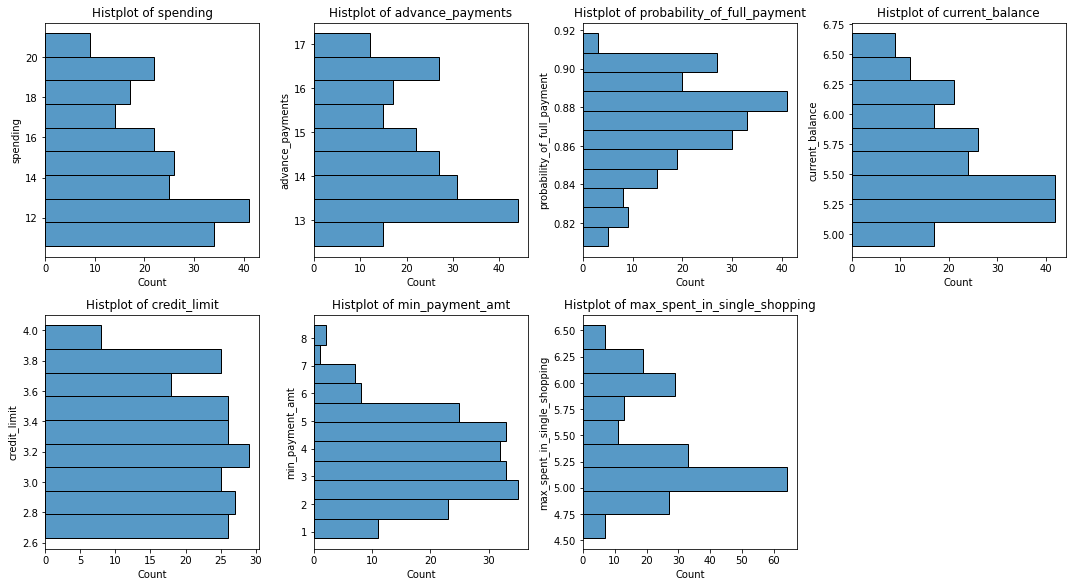

In [1295]:
plt.figure(figsize = (15,20))
feature_list = df.columns
for i in range(len(feature_list)):
    plt.subplot(5, 4, i + 1)
    sns.histplot(y = df[feature_list[i]], data = df)
    plt.title('Histplot of {}'.format(feature_list[i]))
    plt.tight_layout()

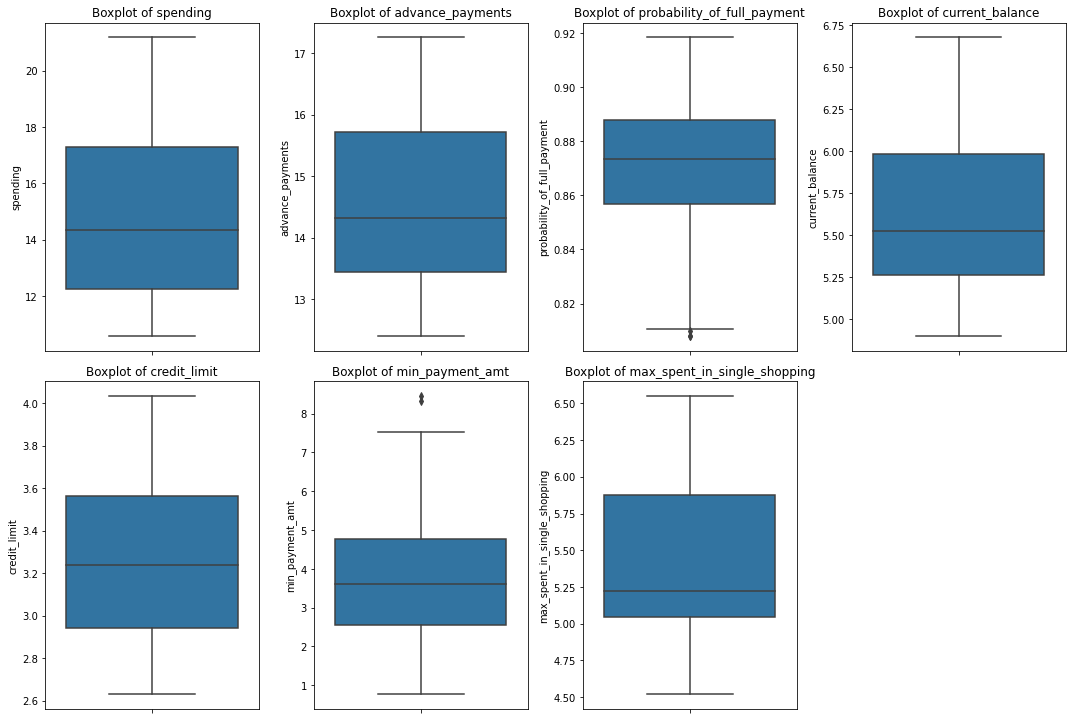

In [1296]:
plt.figure(figsize = (15,25))
feature_list = df.columns
for i in range(len(feature_list)):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y = df[feature_list[i]], data = df)
    plt.title('Boxplot of {}'.format(feature_list[i]))
    plt.tight_layout()

### The data is having outliers in probability_of_full_payment, min_payment_amt.

### 1.2  Do you think scaling is necessary for clustering in this case? Justify

In [1297]:
df.describe()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000


### By using the describe() function we can summarize our data set, from this summary it is clear that the dataset is having datapoints which are far from each other in the available columns. 
### For example: the mean, std dev values in the probability_of_full_payment is very far from the mean, std dev values in other columns of our dataset. Here our clustering algorithm may treat the features with different weightage and may give a nonoptimal output.
### Therefore, It is required to use the scaled data in our clustering algorithms to get optimum output. Standard scaler can be used to scale our dataset by applying the z-score to our datapoints.

In [1298]:
#Scaling the dataset
from sklearn.preprocessing import StandardScaler
X = StandardScaler()
scaled_df = X.fit_transform(df)

In [1299]:
scaled_df

array([[ 1.75435461,  1.81196782,  0.17822987, ...,  1.33857863,
        -0.29880602,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.501773  , ...,  0.85823561,
        -0.24280501, -0.53858174],
       [ 1.41330028,  1.42819249,  0.50487353, ...,  1.317348  ,
        -0.22147129,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36488339, ..., -0.15287318,
        -1.3221578 , -0.83023461],
       [ 0.43836719,  0.33827054,  1.23027698, ...,  0.60081421,
        -0.95348449,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77624835, ..., -0.07325831,
        -0.70681338,  0.96047321]])

### 1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and briefly describe them



In [1300]:
from scipy.cluster.hierarchy import dendrogram, linkage

wardlink = linkage(scaled_df, method = 'ward')

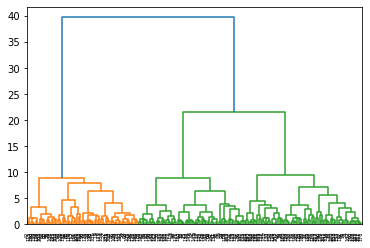

In [1301]:
dend = dendrogram(wardlink)

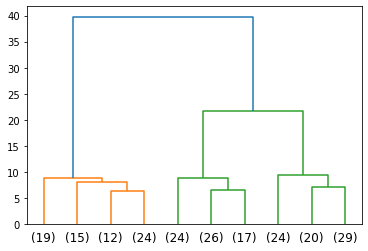

In [1302]:
dend = dendrogram(wardlink,
                 truncate_mode='lastp',
                 p = 10,
                 )

In [1303]:
from scipy.cluster.hierarchy import fcluster

In [1304]:
clusters = fcluster(wardlink, 3, criterion='maxclust')
clusters

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

In [1305]:
df['clusters'] = clusters

In [1306]:
df.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


In [1307]:
df.clusters.value_counts(normalize=True)

3    0.347619
1    0.333333
2    0.319048
Name: clusters, dtype: float64

In [1308]:
df.to_csv('H:\Downloads\clustered.csv')

### 1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score. Explain the results properly. Interpret and write inferences on the finalized clusters.

In [1309]:
scaled_df

array([[ 1.75435461,  1.81196782,  0.17822987, ...,  1.33857863,
        -0.29880602,  2.3289982 ],
       [ 0.39358228,  0.25383997,  1.501773  , ...,  0.85823561,
        -0.24280501, -0.53858174],
       [ 1.41330028,  1.42819249,  0.50487353, ...,  1.317348  ,
        -0.22147129,  1.50910692],
       ...,
       [-0.2816364 , -0.30647202,  0.36488339, ..., -0.15287318,
        -1.3221578 , -0.83023461],
       [ 0.43836719,  0.33827054,  1.23027698, ...,  0.60081421,
        -0.95348449,  0.07123789],
       [ 0.24889256,  0.45340314, -0.77624835, ..., -0.07325831,
        -0.70681338,  0.96047321]])

In [1310]:
wss =[] 

In [1311]:
for i in range(1,11):
    KM = KMeans(n_clusters=i)
    KM.fit(scaled_df)
    wss.append(KM.inertia_)

C:\Users\balar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [1312]:
wss

[1470.0,
 659.1717544870407,
 430.65897315130053,
 371.184612535102,
 326.3676022658376,
 289.24573672030147,
 262.84308146937167,
 239.86691320654558,
 222.1060941419668,
 203.67396688466303]

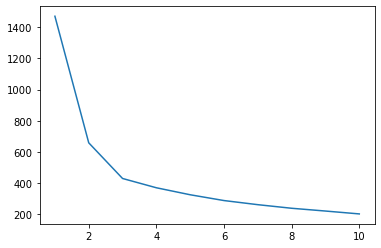

In [1313]:
plt.plot(range(1,11), wss)

In [1314]:
k_means = KMeans(n_clusters = 3)
k_means.fit(scaled_df)
labels = k_means.labels_

In [1315]:
df["Clus_kmeans"] = labels
df.head(5)

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters,Clus_kmeans
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1,0
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3,2
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1,0
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2,1
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1,0


In [1316]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [1317]:
silhouette_score(scaled_df,labels)

0.40072705527512986

In [1318]:
silhouette_samples(scaled_df,labels).min()

0.002713089347678376

In [1319]:
sil_width = silhouette_samples(scaled_df,labels)

In [1320]:
df["sil_width"] = sil_width
df.head(5)

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,clusters,Clus_kmeans,sil_width
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1,0,0.573699
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,3,2,0.366386
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1,0,0.637784
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2,1,0.512458
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1,0,0.362276


In [1321]:
df.Clus_kmeans.value_counts(normalize=True)

1    0.342857
2    0.338095
0    0.319048
Name: Clus_kmeans, dtype: float64

In [1322]:
df.to_csv('H:\Downloads\K-means_clustered.csv')

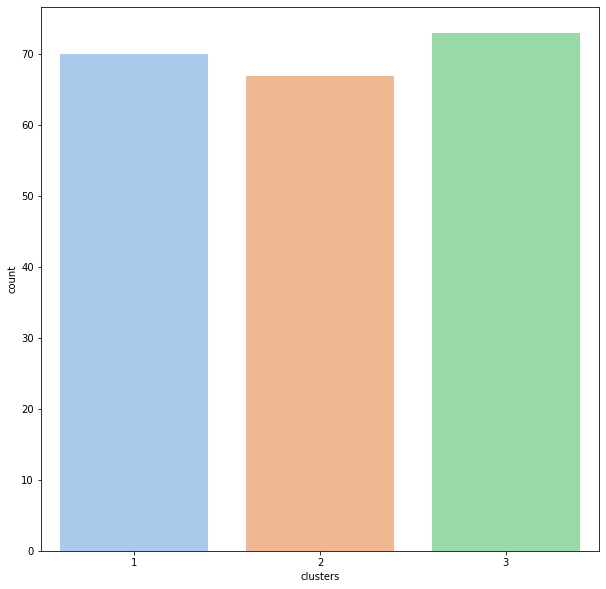

In [1323]:
plt.figure(figsize=(10,10))
sns.countplot(x='clusters', data=df, palette='pastel');

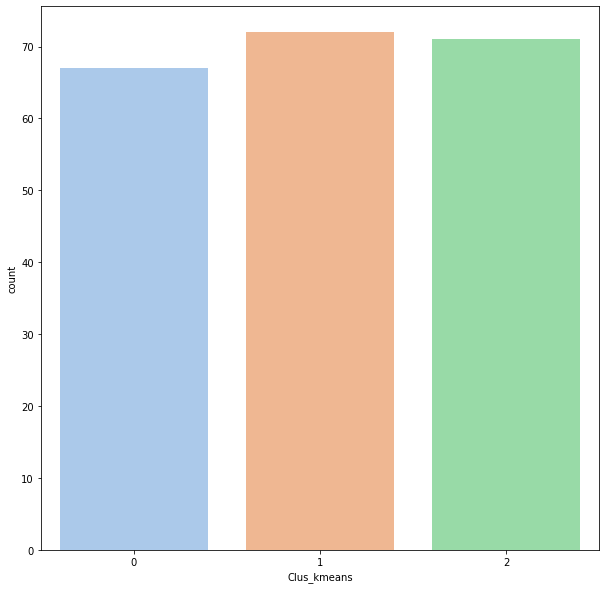

In [1324]:
plt.figure(figsize=(10,10))
sns.countplot(x='Clus_kmeans', data=df, palette='pastel');

### 1.5 Describe cluster profiles for the clusters defined. Recommend different promotional strategies for different clusters.

## Problem 2: CART-RF-ANN

### An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

### 2.1 Read the data, do the necessary initial steps, and exploratory data analysis (Univariate, Bi-variate, and multivariate analysis).

In [1450]:
df_claim = pd.read_csv('H:\Downloads\insurance_part2_data.csv')

In [1425]:
df_claim.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [1426]:
df_claim.describe(include='all')

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
count,3000.000000,3000,3000,3000,3000.000000,3000,3000.000000,3000.000000,3000,3000
unique,NaN,4,2,2,NaN,2,NaN,NaN,5,3
top,NaN,EPX,Travel Agency,No,NaN,Online,NaN,NaN,Customised Plan,ASIA
freq,NaN,1365,1837,2076,NaN,2954,NaN,NaN,1136,2465
mean,38.091000,NaN,NaN,NaN,14.529203,NaN,70.001333,60.249913,NaN,NaN
std,10.463518,NaN,NaN,NaN,25.481455,NaN,134.053313,70.733954,NaN,NaN
min,8.000000,NaN,NaN,NaN,0.000000,NaN,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,0.000000,NaN,11.000000,20.000000,NaN,NaN
50%,36.000000,NaN,NaN,NaN,4.630000,NaN,26.500000,33.000000,NaN,NaN
75%,42.000000,NaN,NaN,NaN,17.235000,NaN,63.000000,69.000000,NaN,NaN


In [1427]:
df_claim.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [1428]:
df_claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [1429]:
df_claim.duplicated().sum()

139

In [1430]:
df_claim['Agency_Code'].value_counts(normalize=True)

EPX    0.455000
C2B    0.308000
CWT    0.157333
JZI    0.079667
Name: Agency_Code, dtype: float64

In [1431]:
df_claim['Type'].value_counts(normalize=True)

Travel Agency    0.612333
Airlines         0.387667
Name: Type, dtype: float64

In [1432]:
df_claim['Claimed'].value_counts(normalize=True)

No     0.692
Yes    0.308
Name: Claimed, dtype: float64

In [1433]:
df_claim['Channel'].value_counts(normalize=True)

Online     0.984667
Offline    0.015333
Name: Channel, dtype: float64

In [1434]:
df_claim['Product Name'].value_counts(normalize=True)

Customised Plan      0.378667
Cancellation Plan    0.226000
Bronze Plan          0.216667
Silver Plan          0.142333
Gold Plan            0.036333
Name: Product Name, dtype: float64

In [1435]:
df_claim['Destination'].value_counts(normalize=True)

ASIA        0.821667
Americas    0.106667
EUROPE      0.071667
Name: Destination, dtype: float64

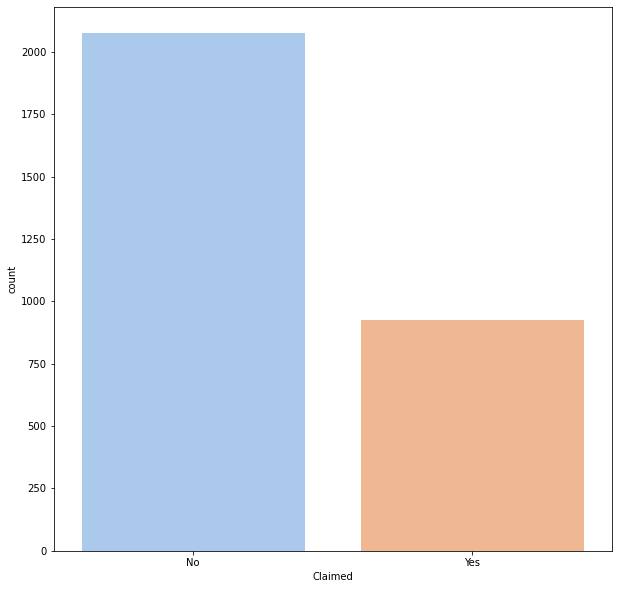

In [1436]:
plt.figure(figsize=(10,10))
sns.countplot(x='Claimed', data=df_claim, palette='pastel');

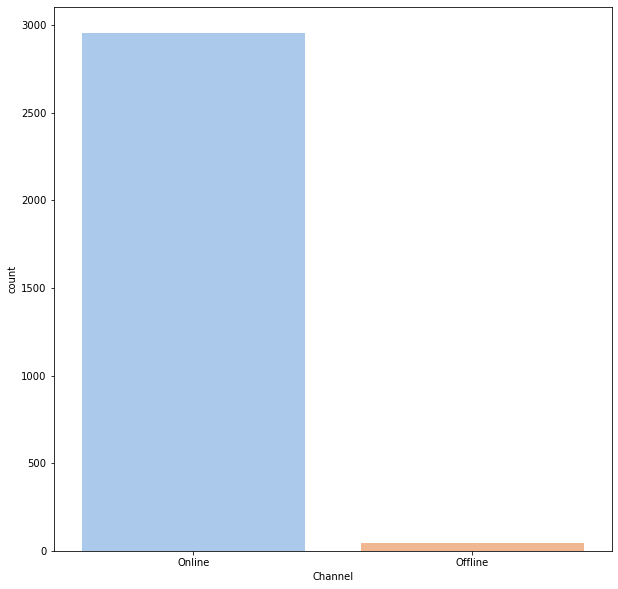

In [1437]:
plt.figure(figsize=(10,10))
sns.countplot(x='Channel', data=df_claim, palette='pastel');

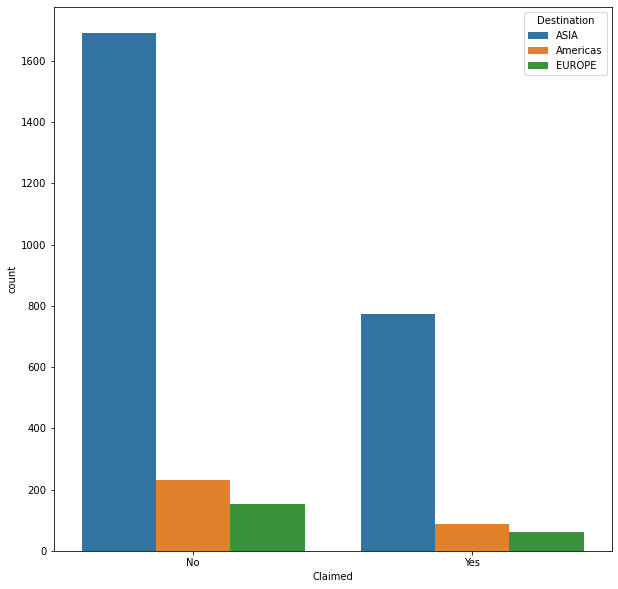

In [1438]:
plt.figure(figsize=(10,10))
sns.countplot(x='Claimed', hue='Destination', data=df_claim);

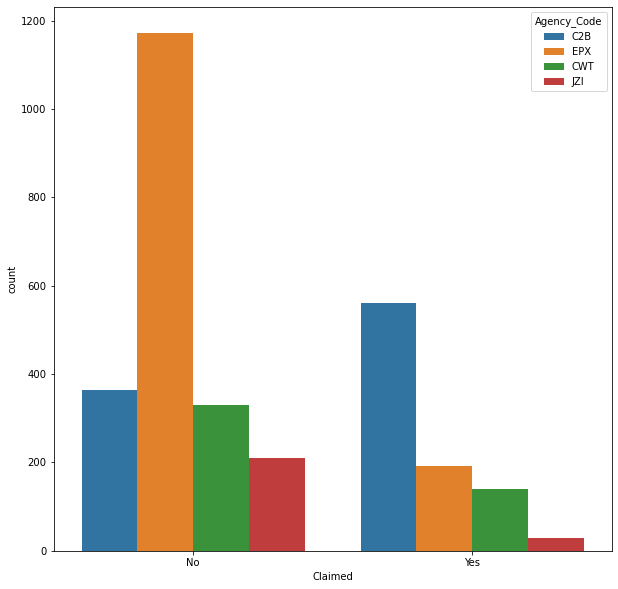

In [1439]:
plt.figure(figsize=(10,10))
sns.countplot(x='Claimed', hue='Agency_Code', data=df_claim);

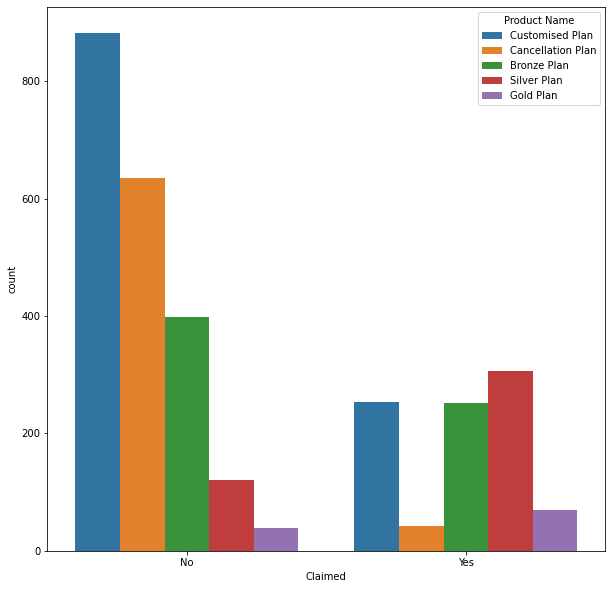

In [1440]:
plt.figure(figsize=(10,10))
sns.countplot(x='Claimed', hue='Product Name', data=df_claim);

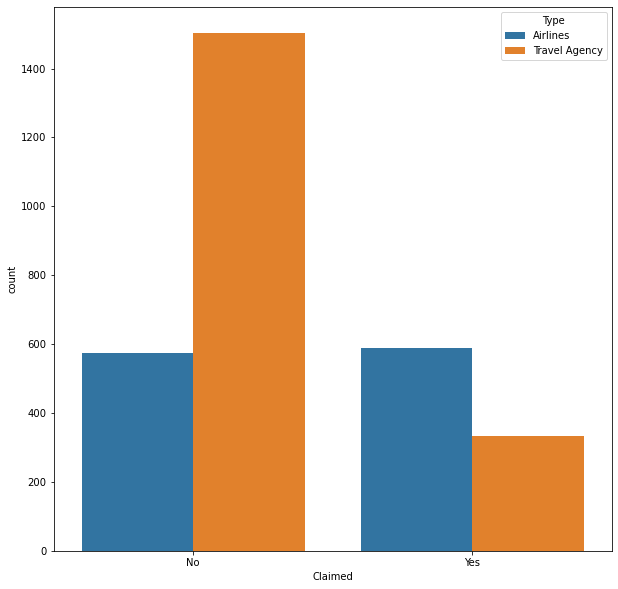

In [1441]:
plt.figure(figsize=(10,10))
sns.countplot(x='Claimed', hue='Type', data=df_claim);

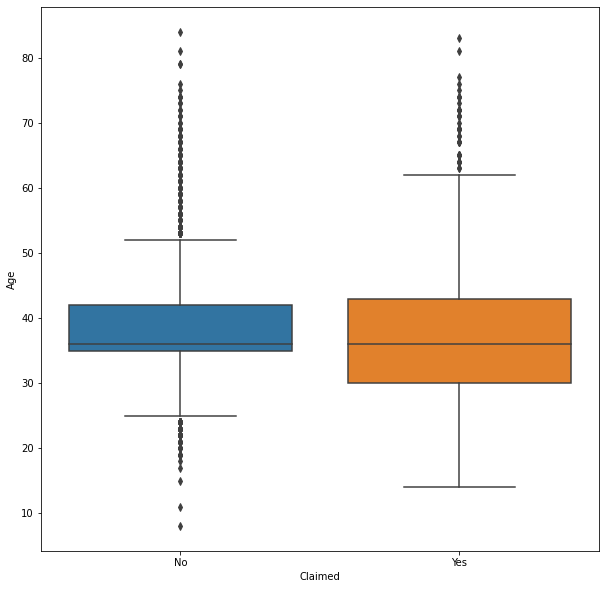

In [1444]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Claimed', y='Age', data=df_claim);

In [1445]:
df_claim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


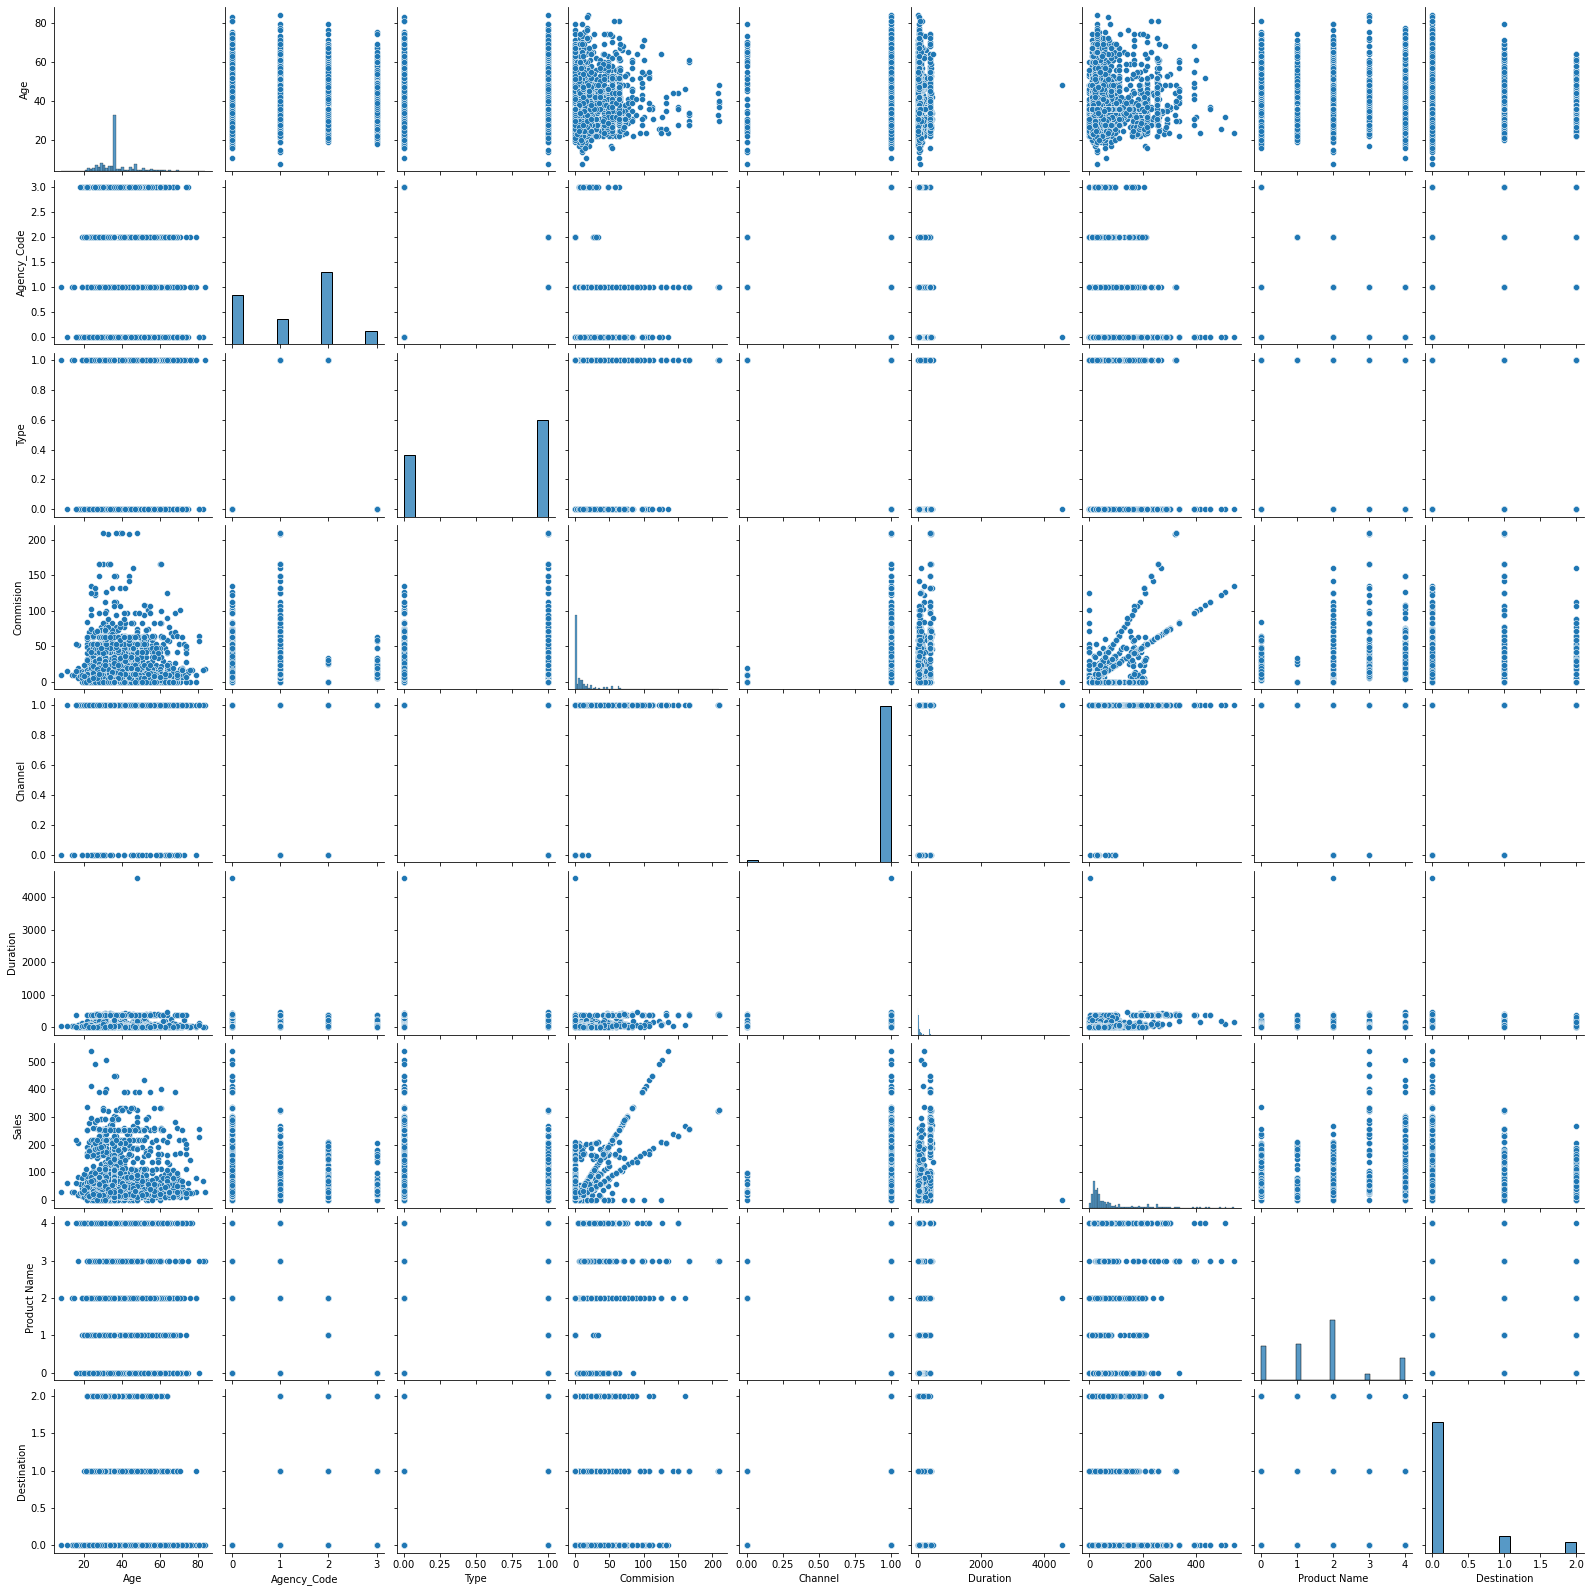

In [1418]:
sns.pairplot(df_claim);

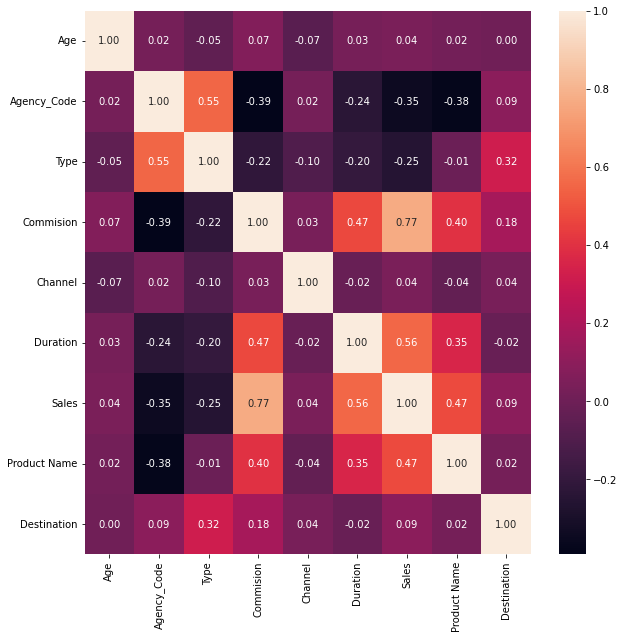

In [1419]:
plt.figure(figsize=(10,10))
sns.heatmap(df_claim.corr(),annot=True,fmt=".2f");

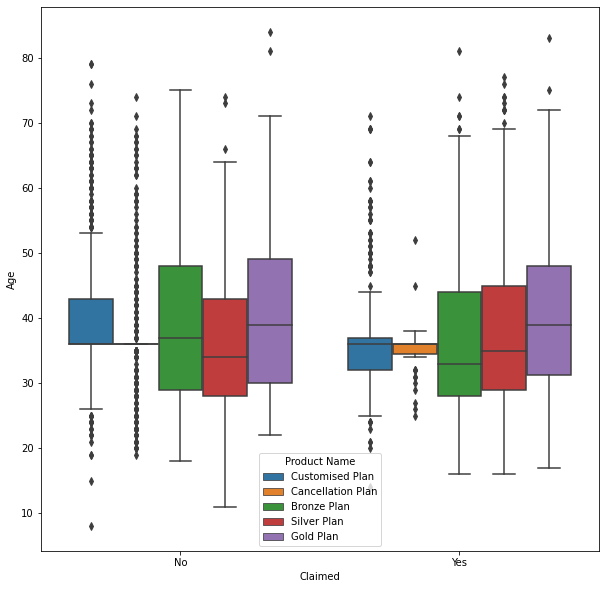

In [1347]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Claimed', y='Age', hue='Product Name',data=df_claim);

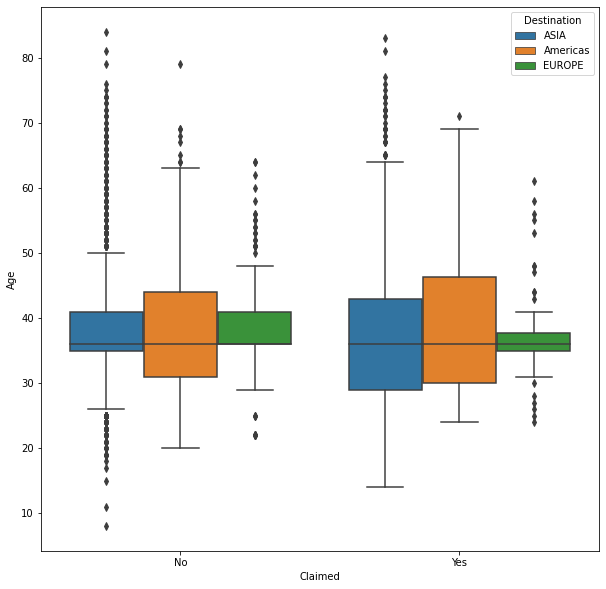

In [1348]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Claimed', y='Age', hue='Destination',data=df_claim);

### 2.2 Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network

In [1451]:
for feature in df_claim.columns: 
    if df_claim[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(df_claim[feature].unique()))
        print(pd.Categorical(df_claim[feature].unique()).codes)
        df_claim[feature] = pd.Categorical(df_claim[feature]).codes



feature: Agency_Code
['C2B', 'EPX', 'CWT', 'JZI']
Categories (4, object): ['C2B', 'CWT', 'EPX', 'JZI']
[0 2 1 3]


feature: Type
['Airlines', 'Travel Agency']
Categories (2, object): ['Airlines', 'Travel Agency']
[0 1]


feature: Claimed
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


feature: Channel
['Online', 'Offline']
Categories (2, object): ['Offline', 'Online']
[1 0]


feature: Product Name
['Customised Plan', 'Cancellation Plan', 'Bronze Plan', 'Silver Plan', 'Gold Plan']
Categories (5, object): ['Bronze Plan', 'Cancellation Plan', 'Customised Plan', 'Gold Plan', 'Silver Plan']
[2 1 0 4 3]


feature: Destination
['ASIA', 'Americas', 'EUROPE']
Categories (3, object): ['ASIA', 'Americas', 'EUROPE']
[0 1 2]


In [1452]:
# capture the target column ("Claimed") into separate vectors for training set and test set

X = df_claim.drop("Claimed" , axis=1)

y = df_claim.pop("Claimed")

In [1453]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=.30, random_state=1)

In [1460]:
X_train.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
1045,36,2,1,0.00,1,30,20.00,2,0
2717,36,2,1,0.00,1,139,42.00,2,1
2835,28,0,0,46.96,1,367,187.85,4,0
2913,28,0,0,12.13,1,29,48.50,4,0
959,48,1,1,18.62,1,53,49.00,3,0


In [1461]:
X_test.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
1957,22,1,1,28.50,1,28,75.0,0,2
2087,55,0,0,6.63,1,24,26.5,0,0
1394,29,0,0,4.00,1,33,16.0,0,0
1520,27,0,0,15.88,1,40,63.5,4,0
1098,36,2,1,0.00,1,35,27.0,1,0


## Decision Tree Classifier

In [1462]:
dt_model = DecisionTreeClassifier()

In [1463]:
# Fit the model
dt_model.fit(X_train, train_labels)

DecisionTreeClassifier()

In [1464]:
from sklearn import tree

train_char_label = ['No', 'Yes']
Claim_Tree_File = open('Claim_Tree_File.dot','w')
dot_data = tree.export_graphviz(dt_model, 
                                out_file=Claim_Tree_File, 
                                feature_names = list(X_train), 
                                class_names = list(train_char_label))

Claim_Tree_File.close()

### Variable Importance

In [1465]:
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))


                   Imp
Duration      0.270830
Sales         0.205663
Agency_Code   0.192824
Age           0.178890
Commision     0.085695
Product Name  0.036325
Destination   0.018593
Channel       0.008852
Type          0.002329


### Predicting Test Data

In [1466]:
y_predict_test = dt_model.predict(X_test)

In [1467]:
y_predict_test #predicted label

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

In [1468]:
test_labels #actual label

1957    0
2087    1
1394    1
1520    1
1098    0
       ..
2363    0
270     0
517     1
2383    0
2201    0
Name: Claimed, Length: 900, dtype: int8

# Regularising the Decision Tree

In [1469]:
reg_dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 30,min_samples_leaf=100,min_samples_split=700, random_state=1)
reg_dt_model.fit(X_train, train_labels)

DecisionTreeClassifier(max_depth=30, min_samples_leaf=100,
                       min_samples_split=700, random_state=1)

### Generating New Tree

In [1470]:
Claim_tree_regularized = open('Claim_tree_regularized.dot','w')
dot_data = tree.export_graphviz(reg_dt_model, out_file= Claim_tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

Claim_tree_regularized.close()
dot_data

### Variable Importance

In [1471]:
print (pd.DataFrame(reg_dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.878256
Sales         0.107774
Product Name  0.013969
Age           0.000000
Type          0.000000
Commision     0.000000
Channel       0.000000
Duration      0.000000
Destination   0.000000


### Predicting on Training and Test dataset

In [1472]:
ytrain_predict = reg_dt_model.predict(X_train)
ytest_predict = reg_dt_model.predict(X_test)

In [1473]:
print('ytrain_predict',ytrain_predict.shape)
print('ytest_predict',ytest_predict.shape)

ytrain_predict (2100,)
ytest_predict (900,)


### Getting the Predicted Classes

In [1474]:
ytest_predict

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,

### Getting the Predicted Probabilities

In [1475]:
ytest_predict_prob=reg_dt_model.predict_proba(X_test)
ytest_predict_prob

array([[0.74343122, 0.25656878],
       [0.4119403 , 0.5880597 ],
       [0.4119403 , 0.5880597 ],
       ...,
       [0.4119403 , 0.5880597 ],
       [0.94883721, 0.05116279],
       [0.94883721, 0.05116279]])

In [1476]:
 pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.743431,0.256569
1,0.411940,0.588060
2,0.411940,0.588060
3,0.411940,0.588060
4,0.948837,0.051163


# Model Evaluation for CART

## Measuring AUC-ROC Curve

### AUC and ROC for the training data

AUC: 0.772


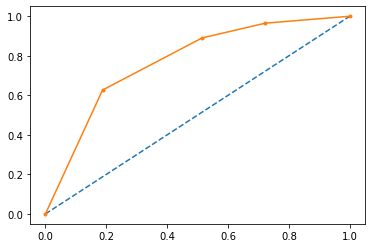

In [1477]:
# predict probabilities
probs = reg_dt_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(train_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

### AUC and ROC for the test data

AUC: 0.760


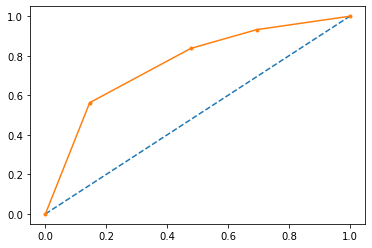

In [1478]:
# predict probabilities
probs = reg_dt_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_labels, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_labels, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

## Confusion Matrix for the training data

In [1479]:
from sklearn.metrics import classification_report,confusion_matrix

In [1480]:
confusion_matrix(train_labels, ytrain_predict)

array([[1195,  276],
       [ 235,  394]], dtype=int64)

In [1481]:
#Train Data Accuracy
reg_dt_model.score(X_train,train_labels) 

0.7566666666666667

In [1482]:
print(classification_report(train_labels, ytrain_predict))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1471
           1       0.59      0.63      0.61       629

    accuracy                           0.76      2100
   macro avg       0.71      0.72      0.72      2100
weighted avg       0.76      0.76      0.76      2100



## Confusion Matrix for test data

In [1483]:
confusion_matrix(test_labels, ytest_predict)

array([[517,  88],
       [129, 166]], dtype=int64)

In [1484]:
#Test Data Accuracy
reg_dt_model.score(X_test,test_labels)

0.7588888888888888

In [1485]:
print(classification_report(test_labels, ytest_predict))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       605
           1       0.65      0.56      0.60       295

    accuracy                           0.76       900
   macro avg       0.73      0.71      0.72       900
weighted avg       0.75      0.76      0.75       900



## Random Forest Classifier

In [1488]:
#Build a RandomForestCassifier wit n_estimators 100, max_features 6, andfit it on the training data
rfcl = RandomForestClassifier(n_estimators=100, max_features= 6, random_state=100, oob_score=True)


In [1489]:
rfcl.fit(X_train, train_labels).predict(X_train) #training model

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

#### Predicting Train and Test data with the RF Model

In [1490]:
ytrain_predict = rfcl.predict(X_train)
ytest_predict = rfcl.predict(X_test)

ytrain_predict

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

**Train Accuracy**


In [1491]:
rfcl.score(X_train,train_labels)

0.9947619047619047

#### Evaluating model performance with confusion matrix

In [1492]:
from sklearn.metrics import confusion_matrix,classification_report

#### Evaluating model performance on the training data

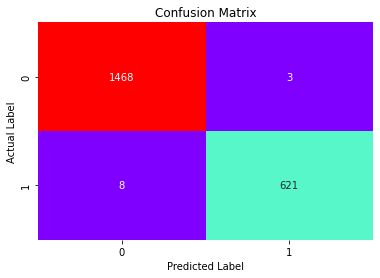

In [1493]:
# Get the confusion matrix on the train data
confusion_matrix(train_labels,ytrain_predict)
sns.heatmap(confusion_matrix(train_labels,ytrain_predict),annot=True, fmt='d',cbar=False, cmap='rainbow')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1382]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1471
           1       1.00      0.99      0.99       629

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



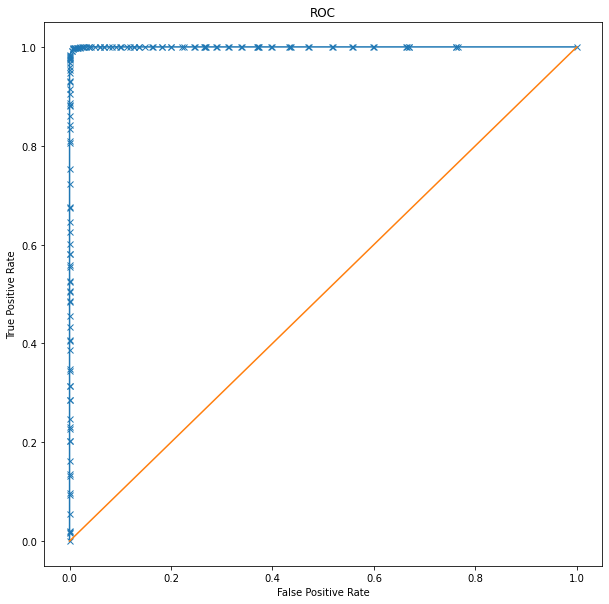

Area under Curve is 0.9998924625429204


In [1383]:
from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(train_labels,rfcl.predict_proba(X_train)[:,1])
plt.figure(figsize=(10,10))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(train_labels,rfcl.predict_proba(X_train)[:,1]))

#### Evaluating model performance on the test data

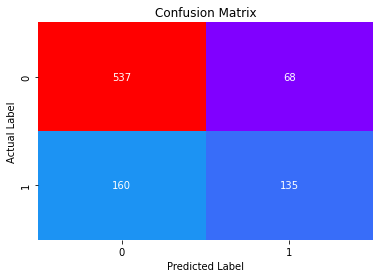

In [1384]:
confusion_matrix(test_labels,ytest_predict)
sns.heatmap(confusion_matrix(test_labels,ytest_predict),annot=True, fmt='d',cbar=False, cmap='rainbow')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [1385]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       605
           1       0.67      0.46      0.54       295

    accuracy                           0.75       900
   macro avg       0.72      0.67      0.68       900
weighted avg       0.74      0.75      0.73       900



**Test Accuracy**

In [1386]:
rfcl.score(X_test,test_labels)

0.7466666666666667

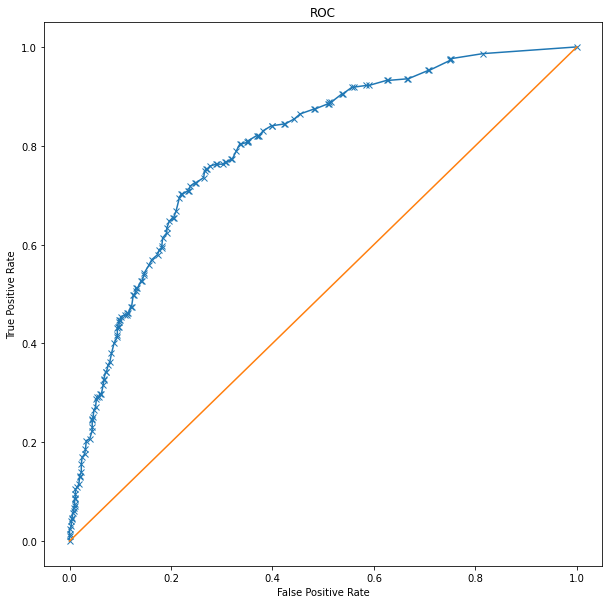

Area under Curve is 0.7980529485922397


In [1387]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(test_labels,rfcl.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(test_labels,rfcl.predict_proba(X_test)[:,1]))

### Applying grid search

In [1495]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [7, 10],
    'max_features': [4,6],
    'min_samples_leaf': [50,100],
    'min_samples_split': [150,300],
    'n_estimators': [100, 200]
}

rfcl = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 3)

In [1496]:
grid_search.fit(X_train, train_labels)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [7, 10], 'max_features': [4, 6],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [150, 300],
                         'n_estimators': [100, 200]})

In [1517]:
grid_search.best_params_

{'max_depth': 7,
 'max_features': 4,
 'min_samples_leaf': 100,
 'min_samples_split': 300,
 'n_estimators': 100}

In [1518]:
best_grid = grid_search.best_estimator_

In [1519]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1520]:
confusion_matrix(train_labels,ytrain_predict)

array([[1341,  130],
       [ 337,  292]], dtype=int64)

In [1521]:
print(classification_report(train_labels,ytrain_predict))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1471
           1       0.69      0.46      0.56       629

    accuracy                           0.78      2100
   macro avg       0.75      0.69      0.70      2100
weighted avg       0.77      0.78      0.76      2100



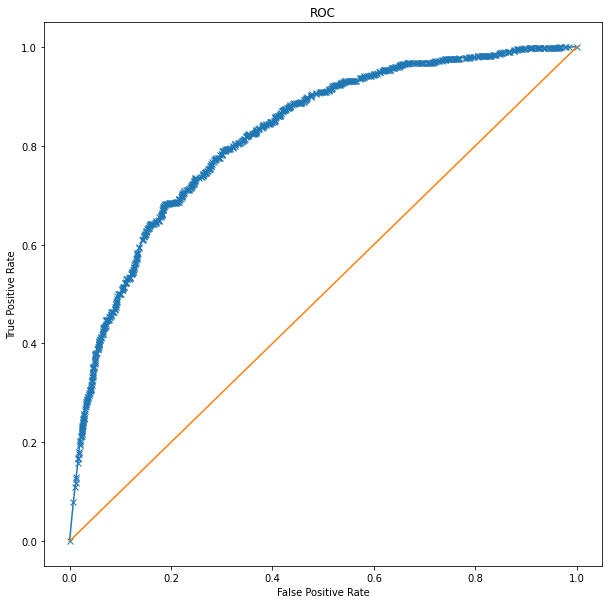

Area under Curve is 0.8212570750460142


In [1522]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(train_labels,best_grid.predict_proba(X_train)[:,1])
plt.figure(figsize=(10,10))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(train_labels,best_grid.predict_proba(X_train)[:,1]))

In [1523]:
confusion_matrix(test_labels,ytest_predict)

array([[566,  39],
       [185, 110]], dtype=int64)

In [1524]:
print(classification_report(test_labels,ytest_predict))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       605
           1       0.74      0.37      0.50       295

    accuracy                           0.75       900
   macro avg       0.75      0.65      0.67       900
weighted avg       0.75      0.75      0.72       900



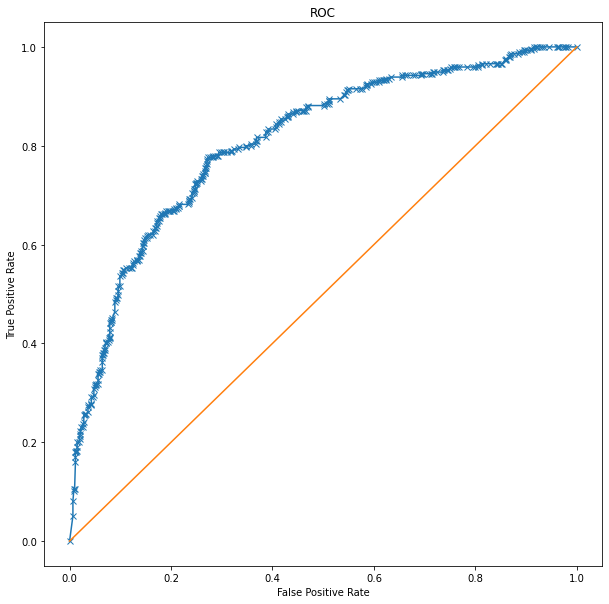

Area under Curve is 0.8079142737078021


In [1525]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(test_labels,best_grid.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(rf_fpr,rf_tpr, marker='x', label='Random Forest')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(test_labels,best_grid.predict_proba(X_test)[:,1]))

## MLP Classifier (Artificial Neural Network)

In [1526]:
#split data into 70% training and 30% test data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)


In [1528]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform (X_test)

In [1541]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [100,200,300,500,600],
    'activation': ['logistic', 'relu'],
    'max_iter': [5000,2500,],
    'solver': ['sgd','adam'],
    'tol': [0.01,0.001],
}

nncl = MLPClassifier(random_state=1)

grid_search = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 10)

In [1542]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=1),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [100, 200, 300, 500, 600],
                         'max_iter': [5000, 2500], 'solver': ['sgd', 'adam'],
                         'tol': [0.01, 0.001]})

In [1543]:
grid_search.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': 300,
 'max_iter': 5000,
 'solver': 'adam',
 'tol': 0.001}

In [1544]:
best_grid = grid_search.best_estimator_

In [1545]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [1546]:
confusion_matrix(y_train,ytrain_predict)

array([[1302,  169],
       [ 278,  351]], dtype=int64)

In [1547]:
print(classification_report(y_train,ytrain_predict))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1471
           1       0.68      0.56      0.61       629

    accuracy                           0.79      2100
   macro avg       0.75      0.72      0.73      2100
weighted avg       0.78      0.79      0.78      2100



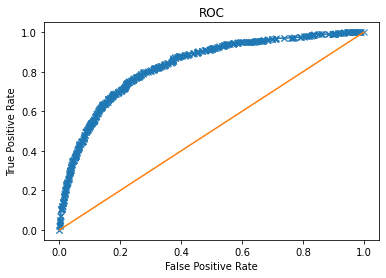

Area under Curve is 0.8322431881235415


In [1548]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(y_train,best_grid.predict_proba(X_train)[:,1])
plt.plot(rf_fpr,rf_tpr, marker='x', label='NN')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(y_train,best_grid.predict_proba(X_train)[:,1]))

In [1549]:
confusion_matrix(y_test,ytest_predict)

array([[552,  53],
       [158, 137]], dtype=int64)

In [1550]:
print(classification_report(y_test,ytest_predict))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       605
           1       0.72      0.46      0.56       295

    accuracy                           0.77       900
   macro avg       0.75      0.69      0.70       900
weighted avg       0.76      0.77      0.75       900



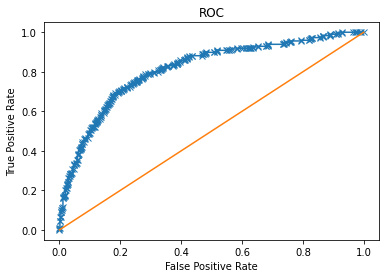

Area under Curve is 0.8134668721109399


In [1551]:
#from sklearn.metrics import roc_curve,roc_auc_score
rf_fpr, rf_tpr,_=roc_curve(y_test,best_grid.predict_proba(X_test)[:,1])
plt.plot(rf_fpr,rf_tpr, marker='x', label='NN')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print('Area under Curve is', roc_auc_score(y_test,best_grid.predict_proba(X_test)[:,1]))

In [1552]:
best_grid.score

<bound method ClassifierMixin.score of MLPClassifier(hidden_layer_sizes=300, max_iter=5000, random_state=1, tol=0.001)>

### 2.3 Performance Metrics: Comment and Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score, classification reports for each model. 

### 2.4 Final Model: Compare all the models and write an inference which model is best/optimized.

### 2.5 Inference: Based on the whole Analysis, what are the business insights and recommendations